In [2]:
import pandas as pd
import numpy as np
import os 
import re
from scipy import stats

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
import sidetable as stb
from sklearn.preprocessing import OneHotEncoder
import squarify


In [4]:
df = pd.read_csv("preparadito.csv", index_col=0)
df.head()

,survey_number,age,gender,country,education_level,programming_experience,programming_language,primary_bd_tool,years_ml,ml_frameworks,ml_algorithms,role,salary,industry,company size,people_in_data,gender_2
0,910,50-54,Man,India,Bachelor’s degree,5-10 years,"Python, R","Local development environments (RStudio, Jupyt...",5-10 years,"Scikit-learn , TensorFlow ,Caret","Linear or Logistic Regression, Decision Trees ...",Other,"25,000-29,999",Manufacturing/Fabrication,NaN,3-4,Man
1,784,50-54,Man,Indonesia,Master’s degree,20+ years,"SQL, C, C++, Java","Advanced statistical software (SPSS, SAS, etc.)",< 1 year,Scikit-learn,"Linear or Logistic Regression, Decision Trees ...",Program/Project Manager,"60,000-69,999",Manufacturing/Fabrication,NaN,1-2,Man
2,924,22-24,Man,Pakistan,Master’s degree,1-3 years,"Python, C++, Java","Basic statistical software (Microsoft Excel, G...",I do not use machine learning methods,NaN,NaN,Software Engineer,$0-999,Academics/Education,NaN,0,Man
3,575,45-49,Man,Mexico,Doctoral degree,20+ years,Python,"Local development environments (RStudio, Jupyt...",5-10 years,"Scikit-learn , TensorFlow ,Keras","Dense Neural Networks (MLPs, etc), Convolutio...",Research Scientist,"30,000-39,999",Academics/Education,NaN,0,Man
4,781,45-49,Man,India,Doctoral degree,< 1 years,"Python, C, MATLAB","Local development environments (RStudio, Jupyt...",10-20 years,"Scikit-learn ,PyTorch ,LightGBM","Linear or Logistic Regression, Decision Trees ...",Other,"30,000-39,999",Academics/Education,NaN,5-9,Man


Hago una copia del df original para utilizar las columnas que me interesan: survey_number, age, gender, country, education_level. Elimino el resto de columnas para que no me molesten al hacer el análisis.

In [5]:
df_almu = df.copy()

In [6]:
df_almu.columns

Index(['survey_number', 'age', 'gender', 'country', 'education_level',
       'programming_experience', 'programming_language', 'primary_bd_tool',
       'years_ml', 'ml_frameworks', 'ml_algorithms', 'role', 'salary',
       'industry', 'company size', 'people_in_data', 'gender_2'],
      dtype='object')

In [7]:
df_almu = df_almu.drop(['programming_language', 'programming_experience', 'primary_bd_tool',
       'years_ml', 'ml_frameworks', 'ml_algorithms', 'role', 'salary',
       'industry', 'company size', 'people_in_data',], axis = 1)

A partir de aquí, hago un análisis previo de las columnas: forma, tipo de columna, qué datos tiene.

In [8]:
df_almu.sample(3)

,survey_number,age,gender,country,education_level,gender_2
2929,593,25-29,Woman,France,Master’s degree,Woman
4628,242,22-24,Man,Kazakhstan,Master’s degree,Man
11894,570,25-29,Man,India,Bachelor’s degree,Man


In [9]:
df_almu.columns

Index(['survey_number', 'age', 'gender', 'country', 'education_level',
       'gender_2'],
      dtype='object')

In [10]:
print(df_almu['country'].dtype)
print(df_almu['age'].dtype)
print(df_almu['gender'].dtype)
print(df_almu['education_level'].dtype)
print(df_almu['gender_2'].dtype)
print(df_almu['survey_number'].dtype)

object
object
object
object
object
int64


Todas las columnas son de tipo object salvo survey_number. El siguiente paso es comprobar cuántos nulos hay por columna.

In [11]:
df_almu.isna().sum()        #Al parecer no hay nulos en ninguna de las columnas.

survey_number      0
age                0
gender             0
country            0
education_level    0
gender_2           0
dtype: int64

In [12]:
df_almu['age'].unique()         #La columna age está dividida por grupos de edad. Es de tipo string por el guión que los une.

array(['50-54', '22-24', '45-49', '25-29', '18-21', '30-34', '40-44',
       '35-39', '70+', '55-59', '60-69'], dtype=object)

In [13]:
df["age"].value_counts()

25-29    4931
18-21    4901
22-24    4694
30-34    3441
35-39    2504
40-44    1890
45-49    1375
50-54     964
55-59     592
60-69     553
70+       128
Name: age, dtype: int64

In [14]:
df_almu['country'].unique()

array(['India', 'Indonesia', 'Pakistan', 'Mexico', 'Russia', 'Turkey',
       'Australia', 'Nigeria', 'Greece', 'Belgium', 'Japan', 'Egypt',
       'Singapore', 'Brazil', 'Poland', 'China',
       'Iran, Islamic Republic of...', 'United States of America',
       'Italy', 'Viet Nam', 'Israel', 'Peru', 'South Africa', 'Other',
       'Spain', 'Bangladesh',
       'United Kingdom of Great Britain and Northern Ireland', 'France',
       'Switzerland', 'Algeria', 'Tunisia', 'Argentina', 'Sweden',
       'Colombia', 'I do not wish to disclose my location', 'Canada',
       'Chile', 'Netherlands', 'Ukraine', 'Saudi Arabia', 'Romania',
       'Morocco', 'Austria', 'Taiwan', 'Kenya', 'Belarus', 'Ireland',
       'Portugal', 'Hong Kong (S.A.R.)', 'Denmark', 'Germany',
       'South Korea', 'Philippines', 'Sri Lanka', 'United Arab Emirates',
       'Uganda', 'Ghana', 'Malaysia', 'Thailand', 'Nepal', 'Kazakhstan',
       'Ethiopia', 'Iraq', 'Ecuador', 'Norway', 'Czech Republic'],
      dtype=obje

Quizás podría ser interesante hacer un análisis por continente (teniendo en cuenta que hay algunos que tienen más respuestas que otros). Asimismo, podría ser interesante unir la celda "others" con "I do not wish to disclose my location". A nivel de estudio de datos son lo mismo. Para ello, creamos una nueva columna llamada "country_2" en la que todos aparezcan por su nombre salvo estas dos excepciones. 

In [15]:
def funcion (columna):
    if columna == 'Other':
        return "Unspecified"
    elif columna == 'I do not wish to disclose my location':
        return "Unspecified"
    elif columna == 'Viet Nam':
        return 'Vietnam'
    else: 
        return columna

In [16]:
df["country_2"] = df["country"].apply(funcion)

In [17]:
df["country_2"].unique()

array(['India', 'Indonesia', 'Pakistan', 'Mexico', 'Russia', 'Turkey',
       'Australia', 'Nigeria', 'Greece', 'Belgium', 'Japan', 'Egypt',
       'Singapore', 'Brazil', 'Poland', 'China',
       'Iran, Islamic Republic of...', 'United States of America',
       'Italy', 'Vietnam', 'Israel', 'Peru', 'South Africa',
       'Unspecified', 'Spain', 'Bangladesh',
       'United Kingdom of Great Britain and Northern Ireland', 'France',
       'Switzerland', 'Algeria', 'Tunisia', 'Argentina', 'Sweden',
       'Colombia', 'Canada', 'Chile', 'Netherlands', 'Ukraine',
       'Saudi Arabia', 'Romania', 'Morocco', 'Austria', 'Taiwan', 'Kenya',
       'Belarus', 'Ireland', 'Portugal', 'Hong Kong (S.A.R.)', 'Denmark',
       'Germany', 'South Korea', 'Philippines', 'Sri Lanka',
       'United Arab Emirates', 'Uganda', 'Ghana', 'Malaysia', 'Thailand',
       'Nepal', 'Kazakhstan', 'Ethiopia', 'Iraq', 'Ecuador', 'Norway',
       'Czech Republic'], dtype=object)

In [18]:
df["education_level"].unique()

array(['Bachelor’s degree', 'Master’s degree', 'Doctoral degree',
       'I prefer not to answer',
       'Some college/university study without earning a bachelor’s degree',
       'No formal education past high school', 'Professional doctorate'],
      dtype=object)

In [19]:
df["country_2"].value_counts()

India                       7434
United States of America    2650
Unspecified                 1339
Japan                        921
China                        814
                            ... 
Kazakhstan                    45
Norway                        45
Algeria                       44
Ethiopia                      43
Iraq                          43
Name: country_2, Length: 65, dtype: int64

In [20]:
df["education_level"].value_counts()

Master’s degree                                                      10132
Bachelor’s degree                                                     9907
Doctoral degree                                                       2795
Some college/university study without earning a bachelor’s degree     1735
I prefer not to answer                                                 627
No formal education past high school                                   417
Professional doctorate                                                 360
Name: education_level, dtype: int64

### Visualización

Prueba 1: treemap de distribución de género

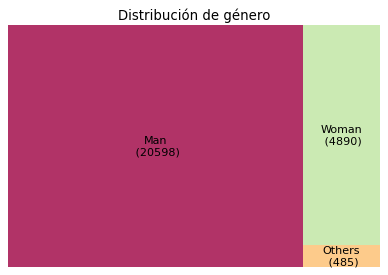

In [21]:
# Prepare Data
df = df_almu.groupby('gender_2').size().reset_index(name='género')
labels = df.apply(lambda x: str(x[0]) + "\n (" + str(x[1]) + ")", axis=1)
sizes = df['género'].values.tolist()
colors = [plt.cm.Spectral(i/float(len(labels))) for i in range(len(labels))]

# Draw Plot
plt.figure(figsize=(6,4), dpi= 80)
squarify.plot(sizes=sizes, label=labels, color=colors, alpha=.8)

# Decorate
plt.title('Distribución de género')
plt.axis('off')
plt.show()

Prueba 2: pie de distribución de género

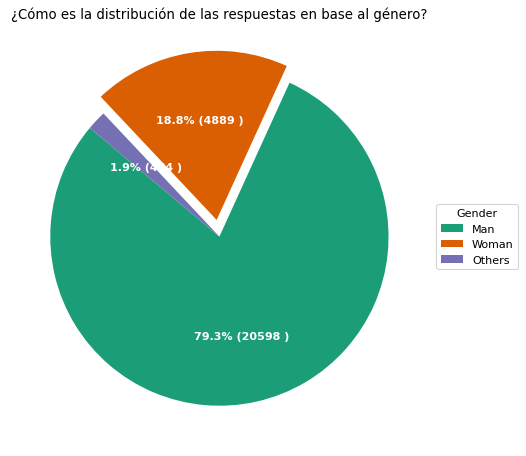

In [35]:
# Prepare Data
df = df_almu.groupby('gender_2').size().reset_index(name='género')

# Draw Plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi= 80)

data = df_almu['gender_2'].value_counts()
categories = df_almu['gender_2'].unique()
explode = [0,0.1,0]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=plt.cm.Dark2.colors,
                                 startangle=140,
                                 explode=explode)

# Decoration
ax.legend(wedges, categories, title="Gender", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("¿Cómo es la distribución de las respuestas en base al género?")
plt.show()

Treemap país

In [28]:
paises_primeros = df_almu.stb.freq(['country'])[0:10]
paises_primeros

paises_10 = df_almu[df_almu["country"].isin(paises_primeros["country"])]
paises_10.head(2)

,survey_number,age,gender,country,education_level,gender_2
0,910,50-54,Man,India,Bachelor’s degree,Man
2,924,22-24,Man,Pakistan,Master’s degree,Man


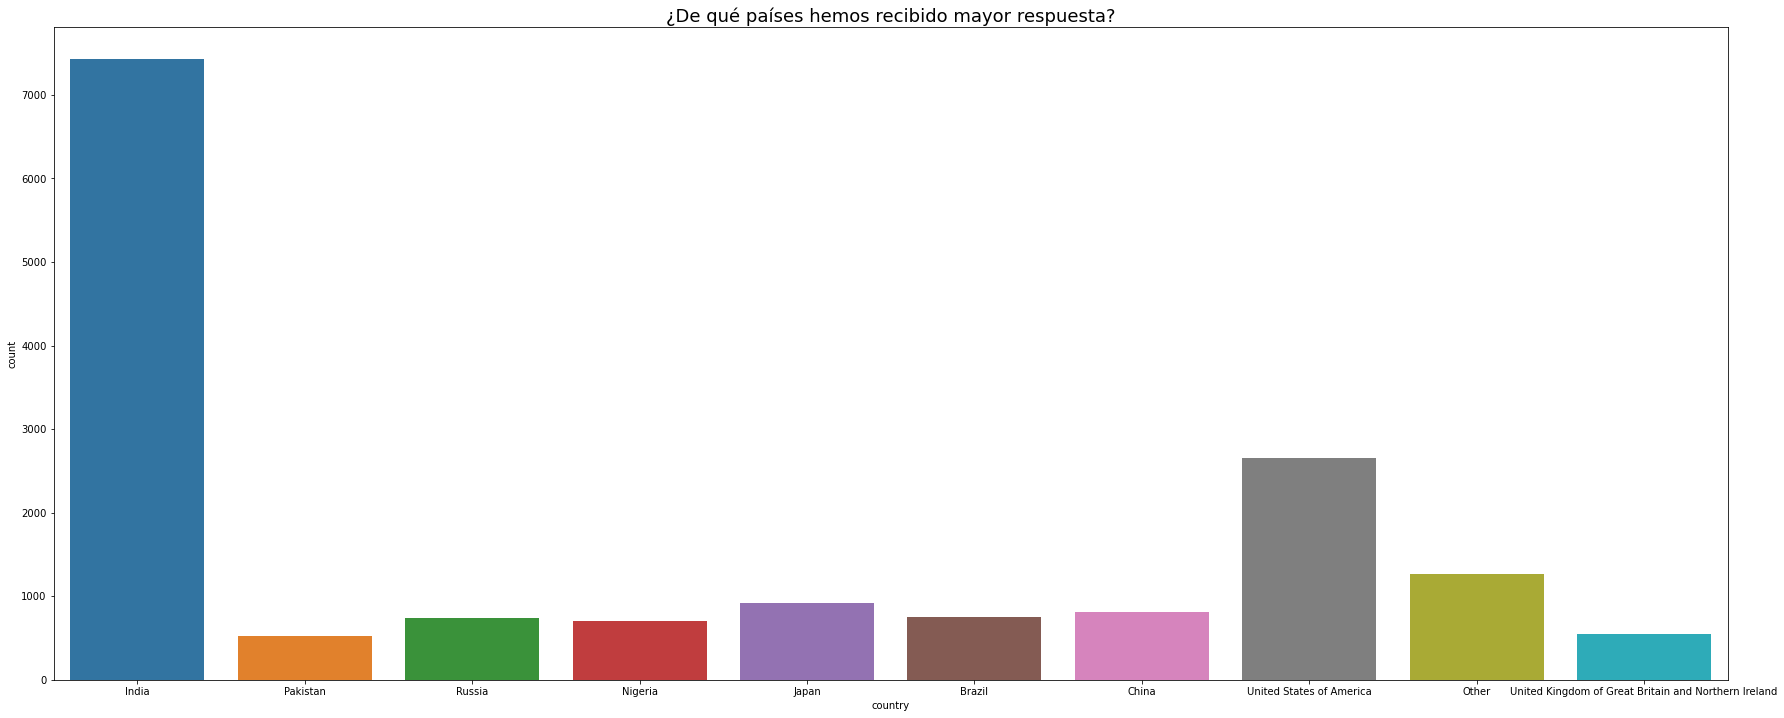

In [34]:
plt.figure(figsize =(30,12)) 
fig = sns.countplot(x= 'country', data = paises_10) 
fig.set_title('¿De qué países hemos recibido mayor respuesta?', fontsize = 18)
plt.show()